In [8]:
import pystan
import arviz
import random
import pandas as pd
import math
import csv
import numpy
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

<b>load the data</b>

In [9]:
def load_data(csv_file_path):
    data = []
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\n')
        for row in reader:
            data.append(from_str_to_float(row))
    return data

In [10]:
def from_str_to_float(string):
    return float(string[0])

In [11]:
y = load_data('../resource/gmm_data.csv')

<b>plot the data</b>

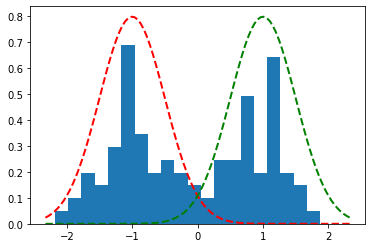

In [12]:
plt.hist(y, bins=20, density=True)
x = numpy.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
plt.plot(x, norm.pdf(x, loc=-1, scale=0.5), 'r--', lw=2)
plt.plot(x, norm.pdf(x, loc=1, scale=0.5), 'g--', lw=2)

<b>inferencing with stan</b>

In [13]:
model = """
data {
 int<lower = 0> N;
 real y[N];
}

parameters {
  vector[2] mu;
  real<lower=0> sigma[2];
}

model {
 mu ~ normal(0, 10);
 sigma ~ lognormal(0, 10);
 for (n in 1:N)
   target += log_mix(0.5,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""

In [14]:
gmm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1019bdc5a953977d661c132666b8e89e NOW.


In [15]:
data = {'N':len(y), 'y': y}

In [21]:
%%timeit -n 10
fit = gmm.sampling(data=data, iter=1000, chains=1)

214 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
print(fit)

Inference for Stan model: anon_model_1019bdc5a953977d661c132666b8e89e.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]       0.9  5.3e-3   0.09   0.72   0.84   0.91   0.96   1.06    266    1.0
mu[2]      -1.0  4.7e-3   0.09  -1.16  -1.07   -1.0  -0.93  -0.83    347    1.0
sigma[1]   0.45  4.5e-3   0.07   0.34    0.4   0.44   0.49    0.6    228    1.0
sigma[2]   0.52  4.7e-3   0.07    0.4   0.47   0.51   0.56   0.68    213    1.0
lp__     -131.1    0.08   1.38 -134.4 -131.9 -130.7 -130.0 -129.2    315    1.0

Samples were drawn using NUTS at Sat May  2 14:40:11 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020B9D3D8D48>,
      dtype=object)

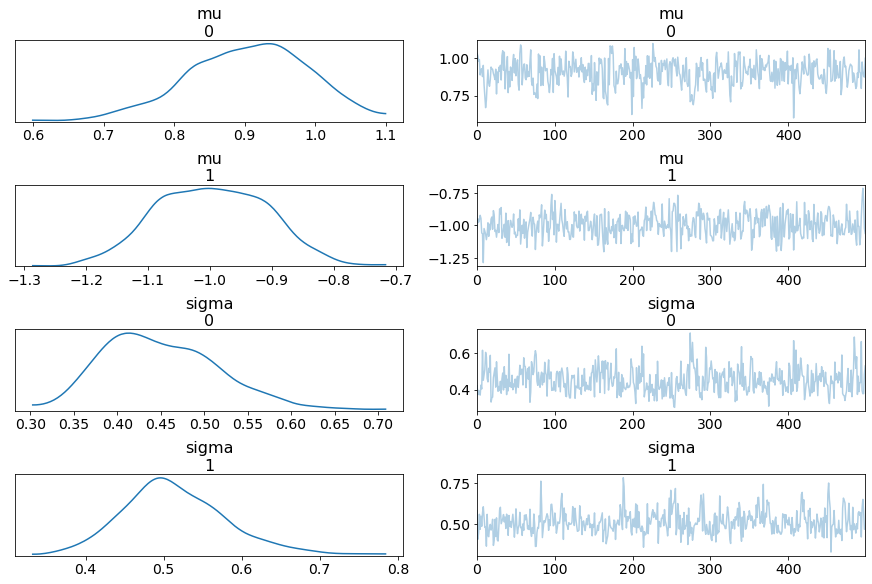

In [18]:
arviz.plot_trace(fit)